In [1]:
%matplotlib inline

import pandas as pd
import os
import os.path as op
import math

import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

cdir = '/mnt/scgc/simon/simonsproject/gorg-tara_clustering'
os.chdir(cdir)

Data prep:

* Downloaded all tropics and subtropics coding sequences used in [this study](http://ocean-microbiome.embl.de/companion.html) that are between 40S and 40N from EBI.  

* Translated all sequences from nt to aa sequences + add prefix to sequence names to indicate they came from TARA.  

* Called proteins from all GORG SAGs using prodigal with the following parameters:
```
prodigal -i {input.nfa} -q -p meta 
```

* add prefix to GORG sequence names to indicate they came from either the BATS248 (BATS248) sample, or Global Surface SAGs (GSS)

* Combined TARA cds sequences and GORG sequences into one large fasta file (called gorg_tara_tropics.faa).

* Run mmseq2 as such:

```
cd /mnt/scgc/simon/simonsproject/gorg-tara_clustering

name=gorg_tara_tropics
qual=80minid_m80

faa=data/${name}.faa
db=analyses/${name}.db
db_clustered=analyses/${name}_${qual}.db_clustered
rep_seqs=analyses/${name}_${qual}.reps
out_fasta=analyses/${name}_${qual}.faa
out_tsv=analyses/${name}_${qual}.tsv
tmp_dir=data/tmp2/

mkdir $tmp_dir

threads=50

mmseqs createdb $faa $db
mmseqs linclust --threads $threads -v 1 --min-seq-id 0.6 --kmer-per-seq 80 $db $db_clustered $tmp_dir
mmseqs result2repseq $db $db_clustered $rep_seqs  --threads $threads
mmseqs result2flat $db $db $rep_seqs $out_fasta --use-fasta-header
mmseqs createtsv $db $db $db_clustered $out_tsv --threads $threads -v 1
```

Which creates a number of output files, the one of interest is ```analyses/gorg_tara_tropics_80minid_m80.tsv```

How many clusters contain both TARA and GORG sequences, and what are their sizes?

In [2]:
tsv_file = "analyses/gorg_tara_tropics_80minid_m80.tsv"

# In output tsv file, the first column (c1) indicates the seed sequence for a given cluster.  
# This will also serve as the cluster name.
# The second column (c2) is a sequence that is a member of the cluster as indicated by c1
tsv = pd.read_csv(tsv_file, sep="\t", names = ['c1','c2'])

# extract source of sequence (TARA, GSS or BATS248)
tsv['source'] = [i.split(".")[0].split("_")[0] for i in tsv['c2']]

Calculate the number of sequences from each source in each cluster (source_count):

In [3]:
source_count = tsv.groupby(['c1','source'])['c2'].count().reset_index().rename(columns={'c2':'seqs_included'})

And pivot to count membership by cluster:

In [4]:
scp = source_count.pivot(columns='source', index='c1', values='seqs_included')

Add count of all GORG sequences in cluster column and total sequences in each cluster.

In [5]:
scp['gorg'] = scp['bats248'] + scp['gorgtropics']
scp['member_count'] = scp['TARA'] + scp['gorg']

In [6]:
scp = scp.fillna(0)

Print out some summary statistics:

In [7]:
total_tara_clusts = len(scp[scp['TARA'] > 0])
total_gorg_clusts = len(scp[scp['gorg'] > 0])
total_clusts = len(scp)

print("There are", total_clusts, "total clusters.")
                        
print("There are", total_tara_clusts, "clusters with sequences from TARA metagenomes,", 
      "that is", round(total_tara_clusts / total_clusts * 100), "% of total clusters.")

print("There are", total_gorg_clusts, "clusters with sequences from GORG dataset,", 
      "that is", round(total_gorg_clusts / total_clusts * 100), "% of total clusters.")

tara_singletons = len(scp[(scp['TARA'] == 1) & (scp['gorg'] == 0)])
gorg_singletons = len(scp[(scp['gorg'] == 1) & (scp['TARA'] == 0)])

print("There are", tara_singletons, "singleton sequences from TARA metagenomes,", "that is", 
      round(tara_singletons / total_tara_clusts * 100), "% of tara clusters and",
      round(tara_singletons / total_clusts * 100), "% of all clusters.")

print("There are", gorg_singletons, "singleton sequences from GORG dataset,",
      "that is",
     round(gorg_singletons / total_gorg_clusts * 100), "% of gorg clusters and",
     round(gorg_singletons / total_clusts * 100), '% of all clusters.')

tara_multi = len(scp[(scp['TARA'] > 1) & (scp['gorg'] == 0)])
gorg_multi = len(scp[(scp['gorg'] > 1) & (scp['TARA'] == 0)])

print("There are", tara_multi, "multi-sequence clusters only in TARA metagenomes,",
      "that is", 
      round(tara_multi / total_tara_clusts * 100), "% of tara clusters and",
      round(tara_multi / total_clusts * 100), "% of all clusters.")

print("There are", gorg_multi, "multi-sequence clusters only in GORG dataset,","that is",
     round(gorg_multi / total_gorg_clusts * 100), "% of gorg clusters and",
     round(gorg_multi / total_clusts * 100, 2), '% of all clusters.')

shared_clusts = len(scp[(scp['TARA'] > 0) & (scp['gorg'] > 0)])

print("There are", shared_clusts, "clusters shared between TARA and GORG,",
      "that is", round(shared_clusts / total_clusts * 100), "% of all clusters")

There are 34855553 total clusters.
There are 34351307 clusters with sequences from TARA metagenomes, that is 99 % of total clusters.
There are 221401 clusters with sequences from GORG dataset, that is 1 % of total clusters.
There are 22411436 singleton sequences from TARA metagenomes, that is 65 % of tara clusters and 64 % of all clusters.
There are 0 singleton sequences from GORG dataset, that is 0 % of gorg clusters and 0 % of all clusters.
There are 11733402 multi-sequence clusters only in TARA metagenomes, that is 34 % of tara clusters and 34 % of all clusters.
There are 14932 multi-sequence clusters only in GORG dataset, that is 7 % of gorg clusters and 0.04 % of all clusters.
There are 206469 clusters shared between TARA and GORG, that is 1 % of all clusters


In [8]:
scp.to_csv("gorg_tara_tropics_80minid_kmer80_counts_by_source.csv", index=True)

In [9]:
scp.head()

source,TARA,bats248,gorgtropics,gorg,member_count
c1,,,,,
TARA_004_DCM_0.22-1.6_C22365543_1_gene422493,1.0,0.0,0.0,0.0,0.0
TARA_004_DCM_0.22-1.6_C22365545_1_gene422494,1.0,0.0,0.0,0.0,0.0
TARA_004_DCM_0.22-1.6_C22365547_1_gene422497,1.0,0.0,0.0,0.0,0.0
TARA_004_DCM_0.22-1.6_C22365549_1_gene422498,1.0,0.0,0.0,0.0,0.0
TARA_004_DCM_0.22-1.6_C22365551_1_gene422500,1.0,0.0,0.0,0.0,0.0


The above takes a while and requires a good amount of RAM.  I ran it, and then closed my notebook session for the day + reloaded the saved dataframe.

Next Question: 
How are sequences from GORG and TARA distributed amongst clusters?

In [10]:
df = pd.read_csv("/mnt/scgc/simon/simonsproject/gorg-tara_clustering/analyses/gorg_tara_tropics_80minid_kmer80_counts_by_source.csv")[['c1','TARA','gorg']]


In [11]:
df['total'] = df[['TARA','gorg']].sum(axis=1)
df['contains_gorg'] = [1 if i > 0 else 0 for i in df['gorg']]
df['contains_tara'] = [1 if i > 0 else 0 for i in df['TARA']]

binsplits = [0,1, 10, 100, 1000, 5000, 12000]
df['bin'] = pd.cut(df['total'], bins=binsplits)


In [12]:
tp = df.groupby(['bin','contains_gorg','contains_tara'])['total'].count().reset_index().rename(columns={'total':'bin_count'})
ncd = dict(zip(list(tp['bin'].drop_duplicates()), ['1', '2-10','11-100','101-1000', '1001-5000','5001-12000']))
tp['bin_label'] = [ncd[i] for i in tp['bin']]
tp['gorg-presence'] = ["GORG" if i == 1 else "" for i in tp['contains_gorg']]
tp['tara-presence'] = ["Tara" if i == 1 else "" for i in tp['contains_tara']]
tp['membership'] = tp['gorg-presence'] + " and " + tp['tara-presence'] + ' containing'
tp['membership'] = [i if i == 'GORG and Tara containing' else i.replace(" and ","") + " only" for i in tp['membership']]
bin_sums = tp.groupby('bin')['bin_count'].sum().reset_index().rename(columns={'bin_count':'total_bin_count'})
tp = tp.merge(bin_sums, on='bin', how='outer')
tp['log_bin_count'] = [math.log(i, 10) for i in tp['bin_count']]


In [13]:
tp.head()

,bin,contains_gorg,contains_tara,bin_count,bin_label,gorg-presence,tara-presence,membership,total_bin_count,log_bin_count
0,"(0, 1]",0,1,22263710,1,,Tara,Tara containing only,22715792,7.347598
1,"(0, 1]",1,0,452082,1,GORG,,GORG containing only,22715792,5.655217
2,"(1, 10]",0,1,10382961,2-10,,Tara,Tara containing only,11021815,7.016321
3,"(1, 10]",1,0,51304,2-10,GORG,,GORG containing only,11021815,4.710151
4,"(1, 10]",1,1,587550,2-10,GORG,Tara,GORG and Tara containing,11021815,5.769045


/mnt/scgc_nfs/opt/common/anaconda3/4.0.0/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


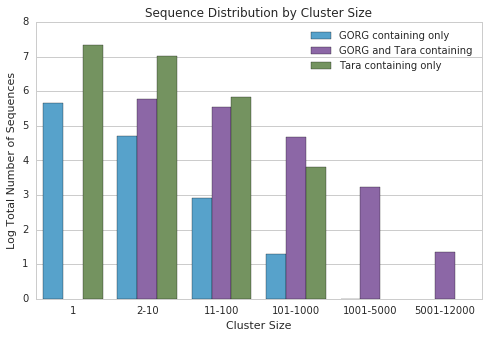

In [15]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
gs = m.gridspec.GridSpec(2,1,height_ratios=[10,1])
ax = plt.subplot(gs[0])

colors = ["#44A8DE",
"#8e5db0",
"#729b57"
]

sns.barplot(x = 'bin_label',
            y = 'log_bin_count',
            hue='membership', 
            data=tp, 
            hue_order=['GORG containing only', 'GORG and Tara containing','Tara containing only'],
           palette = colors)


plt.xlabel('Cluster Size')
plt.ylabel('Log Total Number of Sequences')
plt.title('Sequence Distribution by Cluster Size')
plt.legend(loc=1)

#plt.savefig(op.join(plotdir, "gorg_tara_seq_clust_count_80id_80k.png"), dpi=300)
#plt.savefig(op.join(plotdir, "gorg_tara_seq_clust_count_80id_80k.svg"))